In [62]:
import torch.nn as nn
import torch

In [63]:
class NeuralNetwork(nn.Module):
    """
    Neural Network Class for implementing neural networks for different loss and optimization functions.
    
    Attributes:
        input_size: An integer indicating number of input features.
        output_size: An integer indicating size of output.
        hidden_layer_size: An integer indicating size of hidden layer.
        
        w1: A vector (input_size X hidden_layers_sizes[0]) of floats required for training the neural network.
        wn: A vector (hidden_layers_sizes[-1] X output_size) for weights of final layer.
        
        activations: An array of strings indicating the activation functions for every layer.
        loss: A string indicating the loss function for the neural network.
        optimizer: A string indicating the optimization algorithm to be used to train the network.
    """
    def __init__(self, input_size, output_size, hidden_layer_size, activations, loss, optimizer):
        """
        Initializes Neural Network class attributes.
        
        Args:
            input_size (int): Number of features of the input.
            output_size (int): Dimension of output.
            hidden_layer_size (int): Number of neurons in the input layer.
            activations (list): List of strings giving the activations for each layer.
            loss (str): Loss function for the model.
            optimizer (str): Optimization algorithm for the model.
        """
        super(NeuralNetwork, self)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
        self.activations = activations
        self.loss = loss
        self.optimizer = optimizer
    
    
    def forward(self, X, w1=None, wn=None):
        """
        Forward pass of the neural network.
        
        Args:
            X (tensor): Input for the model. 
            w1 (tensor): Weights to be used for the first layer. (Optional Argument)
            wn (tensor): Weights to be used for the final layer. (Optional Argument)
            
        Returns:
            z (list): List of outputs from linear function at each layer.
            a (list): List of activation outputs from each layer.
        """
        if w1 is None:
            w1 = self.w1
        if wn is None:
            wn = self.wn
        z = []
        a = []
        z.append(torch.matmul(X, w1))
        a.append(self.evaluateActivation(self.activations[0])(z[-1]))
        z.append(torch.matmul(a[-1], wn))
        a.append(self.evaluateActivation(self.activations[1])(z[-1]))
        return z, a
    
    
    def backward(self, X, y, z, a, wn=None):
        """
        Backward Pass of the model.
        
        Args:
            X (Tensor): Input Data
            y (Tensor): Output Data
            z (list): List of outputs from linear layers.
            a (list): List of actiation outputs.
            wn (Tensor): Weights from final layer. (Optional Argument)
        """
        if wn is None:
            wn = self.wn
        dW = []
        dL_da_n = self.evaluateLossDerivative()(a[-1], y)
        da_n_dz_n = self.evaluateActivationDerivative(self.activations[1])(z[-1])
        dz_n_dWn = a[0]
        dL_dWn = torch.matmul(dz_n_dWn.T, (dL_da_n * da_n_dz_n))
        
        dz_n_da_1 = wn
        da_1_dz_1 = self.evaluateActivationDerivative(self.activations[0])(z[0])
        dz_1_dW1 = X
        dL_dW1 = torch.matmul(dz_1_dW1.T, (torch.matmul(dL_da_n * da_n_dz_n, dz_n_da_1.T)*da_1_dz_1))
        dW.append(dL_dW1)
        dW.append(dL_dWn)
        return dW
    
    
    def train(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False, decay_rate=0.999, beta1=0.9, beta2=0.999):
        """
        Function to train the neural network.
        """
        funVals = []
        ypred = None
        if self.optimizer == 'SGD':
            if momentum_param != 0:
                if nesterov:
                    funVals ,ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param, True)
                else:
                    funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param)
            else:
                funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'Adagrad':
            funVals, ypred = self.Adagrad(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'RMSProp':
            funVals, ypred = self.RMSProp(X, y, batch_size, iterations, alpha, decay_rate)
        elif self.optimizer == 'Adam':
            funVals, ypred = self.Adam(X, y, batch_size, iterations, alpha, beta1, beta2)
        return funVals, ypred
    
    
    def SGD(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False):
        """
        Gradient Descent Algorithm
        """
        m, n = X.shape
        funVals = []
        ypred = []
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        vn = torch.zeros(self.wn.shape, dtype=torch.double)
        n_iter = 0
        flag = True
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                if nesterov:
                    z, a = self.forward(X[i:i+batch_size], self.w1+momentum_param*v1, self.wn+momentum_param*vn)
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a, self.wn+momentum_param*vn)
                else:
                    z, a = self.forward(X[i:i+batch_size])
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                v1 = momentum_param * v1 - alpha * dW[0]
                vn = momentum_param * vn - alpha * dW[1]
                self.w1 = self.w1 + v1
                self.wn = self.wn + vn
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adagrad(self, X, y, batch_size=100, iterations=500, alpha=1e-5):
        """
        AdaGrad Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 += dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1)+smoothing_param)) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2)+smoothing_param)) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def RMSProp(self, X, y, batch_size=100, iterations=500, alpha=1e-04, decay_rate=0.999):
        """
        RMSProp Optimizer.
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 = decay_rate*cache1 + (1 - decay_rate) * dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1+smoothing_param))) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2+smoothing_param))) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
#                     print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adam(self, X, y, batch_size=100, iterations=500, alpha=1e-04, beta1=0.9, beta2=0.999):
        """
        Adam Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        m1 = torch.zeros(self.w1.shape, dtype=torch.double)
        m2 = torch.zeros(self.wn.shape, dtype=torch.double)
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        v2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                m1 = beta1 * m1 + (1-beta1) * dW[0]
                v1 = beta2 * v1 + (1-beta2) * dW[0]**2
                m2 = beta1 * m2 + (1-beta1) * dW[1]
                v2 = beta2 * v2 + (1-beta2) * dW[1]**2
                self.w1 += -alpha*(m1/(1-beta1**n_iter))/(torch.sqrt((v1)/(1-beta2**n_iter)) + smoothing_param)
                self.wn += -alpha*(m2/(1-beta1**n_iter))/(torch.sqrt((v2)/(1-beta2**n_iter)) + smoothing_param)
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def predict(self, X):
        """
        Predict function
        """
        _, a = self.forward(X)
        return a[-1]
    
    
    def reset_weights(self):
        """
        Reset Weights
        """
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
    
    def evaluateActivation(self, activation):
        """
        Activation function
        """
        if activation == 'sigmoid' :
            return lambda z : torch.exp(z)/(1 + torch.exp(z))
        elif activation == 'relu':
            def relu(z):
                z1 = torch.clone(z)
                return z1.clamp(min=0)
            return relu
        elif activation == 'tanh':
            return lambda z : (2/(1+torch.exp(-2*z))) - 1
        return lambda z : z
    
    
    def evaluateActivationDerivative(self, activation):
        """
        Derivative of Activation Function
        """
        if activation == 'sigmoid':
            sigmoid = lambda z : torch.exp(z)/(1 + torch.exp(z))
            return lambda z : sigmoid(z) * (1 - sigmoid(z))
        elif activation == 'relu':
            def relu_derivative(z):
                z1 = torch.clone(z)
                z1[z>=0] = 1
                z1[z<0] = 0
                return z1
            return relu_derivative
        elif activation == 'tanh':
            tanh = lambda z : (2/(1+torch.exp(-2*z))) - 1
            return lambda z : 1 - tanh(z)**2
        return lambda z : 1
    
    
    def evaluateLoss(self):
        """
        Loss Function
        """
        if self.loss == 'MSE':
            return lambda ypred, y : torch.matmul((ypred - y).T, (ypred - y))/(2*len(y))
        elif self.loss == 'BCELoss':
            return lambda ypred, y : (-1/len(y))*(torch.matmul(y.T, torch.log(ypred)) + torch.matmul((1-y).T, torch.log(1-ypred)))
        elif self.loss == "CELoss":
            def crossEntropyLoss(ypred, y):
                m = y.shape[0]
                prob = self.softmax(ypred)
                log_likelihood = -torch.log(prob[range(m), y.long()])
                loss = torch.sum(log_likelihood)
                return loss/m
            return crossEntropyLoss
        return lambda x : 1
    
    
    def evaluateLossDerivative(self):
        """
        Loss function Derivative
        """
        if self.loss == 'MSE':
            return lambda ypred, y: (ypred - y)/len(y)
        elif self.loss == 'BCELoss':
            return lambda ypred, y: (-1/len(y)) * ((y/ypred) - ((1-y)/(1-ypred)))
        elif self.loss == 'CELoss':
            def crossEntropyLossGradient(ypred, y):
                m = y.shape[0]
                grad = self.softmax(ypred)
                grad[range(m), y.long()] -= 1
                return grad/m
            return crossEntropyLossGradient
        return lambda x : 1
    
    
    def softmax(self, z):
        exps = torch.exp(z - torch.max(z, dim=0).values)
        return exps/torch.sum(exps, dim=1).reshape(-1, 1)

In [64]:
# X = torch.rand(312, 20, dtype=torch.double)
# # y = torch.randint(0, 2,(1000, 1)).double()
# # y = torch.randn(312, 1, dtype=torch.double)
# y = torch.randint(0,3,(312, 1)).double()

In [65]:
# model = NeuralNetwork(X.shape[1], 3, 32, ['tanh', 'linear'], 'CELoss', 'SGD')

In [66]:
# funVals, ypred = model.train(X, y, batch_size=100, iterations=1500, alpha=1e-03, momentum_param=0.9, nesterov=True)

In [67]:
# print((torch.sum(ypred.argmax(dim=1).reshape(-1,1) == y.long()).float()*100.0)/(y.shape[0]))

In [68]:
# %matplotlib inline
# # def plotLoss(funVals, filePath, title):
# import matplotlib.pyplot as plt
# plt.plot([i for i in range(1, len(funVals)+1)], funVals)
# plt.xlabel("Number of Iterations")
# plt.ylabel("Loss")

In [69]:
%matplotlib inline
def plotLoss(funVals, filePath, title, plot=False):
    import matplotlib.pyplot as plt
    plt.plot([i for i in range(1, len(funVals)+1)], funVals)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    if plot:
        plt.show()
    else:
        plt.savefig("./dataset/"+filePath)

In [70]:
def loadAutoMPGDataset():
    import pandas as pd
    auto_mpg_dataset = pd.read_csv("./dataset/auto-mpg/auto-mpg.data", header=-1, comment='\t', skipinitialspace=True, na_values='?', sep=' ')
    auto_mpg_dataset = auto_mpg_dataset.dropna()
    origin = auto_mpg_dataset.pop(7)
    auto_mpg_dataset[7] = (origin==1)*1.0
    auto_mpg_dataset[8] = (origin==2)*1.0
    auto_mpg_dataset[9] = (origin==3)*1.0
    auto_dataset = torch.tensor(auto_mpg_dataset.values, dtype=torch.double)
    return auto_dataset

In [71]:
auto_dataset = loadAutoMPGDataset()
auto_dataset = auto_dataset[torch.randperm(auto_dataset.shape[0])]

In [72]:
train = auto_dataset[:int(0.8 * auto_dataset.shape[0])]
test = auto_dataset[int(0.8 * auto_dataset.shape[0]):]

Xtrain = train[:, 1:]
Xtrain = (Xtrain - Xtrain.mean(dim=0))/Xtrain.std(dim=0)
ytrain = train[:, 0].reshape(-1, 1)

Xtest = test[:, 1:]
Xtest = (Xtest - Xtest.mean(dim=0))/Xtest.std(dim=0)
ytest = test[:, 0].reshape(-1, 1)

In [73]:
auto_mpg_model = NeuralNetwork(Xtrain.shape[1], ytrain.shape[1], 64, ['relu', 'relu'], 'MSE', 'Adam')

In [74]:
auto_mpg_model.reset_weights()

In [75]:
funVals, ypred = auto_mpg_model.train(Xtrain, ytrain, batch_size=100, iterations=1000, alpha=1e-03)

100 92.35154064724551
200 60.37551350628857
300 16.38864548239426
400 11.228666537004942
500 8.6939875210588
600 7.326550375680231
700 6.5283281835459315
800 5.983569662423891
900 5.56736374660477
1000 5.232870761350045


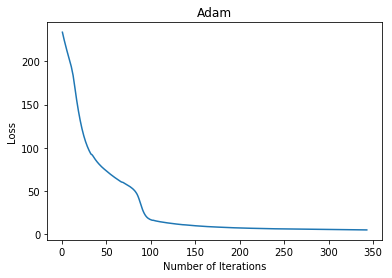

In [76]:
plotLoss(funVals, filePath="auto-mpg/results/Adam.png", title="Adam", plot=True)

In [82]:
optims=['SGD','Adagrad','RMSProp','Adam']
activs=['sigmoid','relu','tanh']
losses=['MSE']#,'BCELoss','CE']
fout = open("results.csv",'w')
fout.write("iter, optim, activ, loss, funVal \n")
for optim in optims:
    for activ in activs:
        for loss in losses:
            print(optim, activ, loss)
            auto_mpg_model = NeuralNetwork(Xtrain.shape[1], ytrain.shape[1], 64, [activ, activ], loss, optim)
            funVals, ypred = auto_mpg_model.train(Xtrain, ytrain, batch_size=100, iterations=1000, alpha=1e-03)
            auto_mpg_model.reset_weights()
            i=0
            for val in funVals:
                fout.write(str(i)+','+optim+','+activ+','+loss+','+str(val)+'\n')
                i+=1
fout.close()

SGD sigmoid MSE
100 281.3443621324879
200 278.9756407987096
300 277.67597624476423
400 277.1080510218557
500 276.879494332755
600 276.77671557261857
700 276.7230097818229
800 276.6912265048343
900 276.67060020861123
1000 276.6562738637025
SGD relu MSE
100 12.835968312016515
200 8.882095906024718
300 7.482811782162537
400 6.729946004421936
500 6.246782495609003
600 5.906065595134786
700 5.650682964972915
800 5.447919760352731
900 5.2756948441564235
1000 5.129248564644239
SGD tanh MSE
100 297.48893951125564
200 297.1973323119136
300 297.06155320429275
400 296.9641230849543
500 296.8839280665665
600 296.8127433554931
700 296.74595609700407
800 296.68009055060736
900 296.61161613102405
1000 296.5357533502525
Adagrad sigmoid MSE
100 293.0983901925828
200 292.0164262976038
300 291.21305684868395
400 290.54309167870355
500 289.9463257941228
600 289.3931628037218
700 288.86813288009375
800 288.3612702607529
900 287.8641558418137
1000 287.3694500923348
Adagrad relu MSE
100 247.59373922546288
20